In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.dropna(axis=0)
    return data


In [4]:
tickers = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM']
start_date = '2010-01-01'
end_date = '2023-05-09'
data = get_data(tickers, start_date, end_date)


[*********************100%***********************]  29 of 29 completed


In [5]:
returns = np.log(data / data.shift(1))
cov_matrix = returns.cov() * 252


In [6]:
def markowitz(weights, cov_matrix):
    port_return = np.sum(returns.mean() * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = port_return / port_volatility
    return np.array([port_return, port_volatility, sharpe_ratio])


In [8]:
num_assets = len(tickers)
weights = np.ones(num_assets) / num_assets
bounds = tuple((0,1) for i in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
result = minimize(lambda x: -markowitz(x, cov_matrix)[2], weights, method='SLSQP', bounds=bounds, constraints=constraints)


In [9]:
# Generate a range of portfolio volatility values
min_volatility = np.min(returns.std() * np.sqrt(252))
max_volatility = np.max(returns.std() * np.sqrt(252))
volatility_range = np.linspace(min_volatility, max_volatility, 100)

# Calculate the corresponding portfolio returns
efficient_frontier = []
for vol in volatility_range:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))) * np.sqrt(252) - vol})
    result = minimize(lambda x: -markowitz(x, cov_matrix)[0], weights, method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_frontier.append([-result.fun, vol])

efficient_frontier = np.array(efficient_frontier)


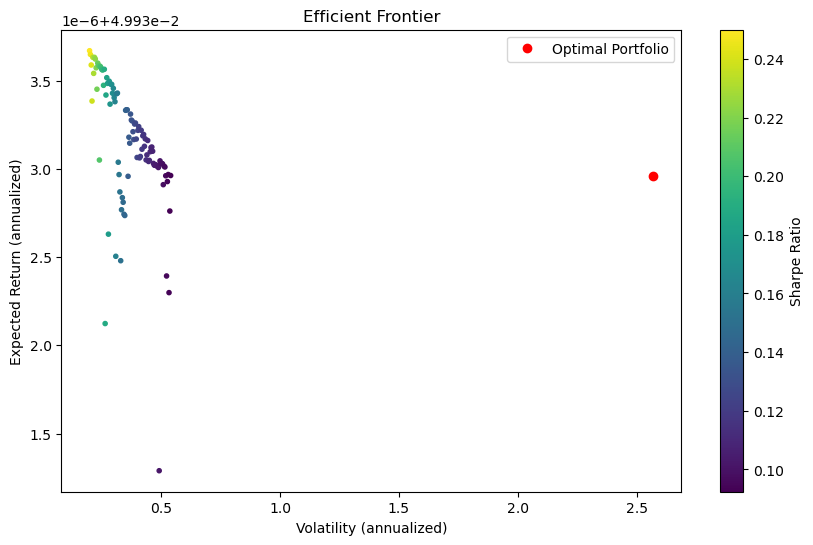

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(efficient_frontier[:, 1], efficient_frontier[:, 0], c=efficient_frontier[:, 0] / efficient_frontier[:, 1], marker='.')
plt.plot(markowitz(result.x, cov_matrix)[1], markowitz(result.x, cov_matrix)[0], 'ro', label='Optimal Portfolio')
plt.xlabel('Volatility (annualized)')
plt.ylabel('Expected Return (annualized)')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.legend()
plt.show()
